# Recommendations Systems
## Course Project

The goal of this project is to let you practice in a data scientist daily work by leveraging recommender
systems algorithms you learnt in the course and customize them in order to solve real business
problems.

We will use a dataset based on the <a href='https://grouplens.org/datasets/movielens/1m/'>MovieLens 1M rating dataset</a> after some pre-processing to adapt it to an implicit feedback use case scenario.  
You can download the dataset used by <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>this implementation</a> of the paper Neural Collaborative Filtering or from the NeuralCollaborativeFiltering_implicit notebook in Moodle.
<br>

## Imports:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

from keras.layers import Embedding, Input, Dense, Reshape,  Flatten, Dropout
from keras.regularizers import l2
from keras import backend as K
from keras import initializers
from keras.initializers import RandomNormal
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras.layers import Multiply, Concatenate

#### Constants:

#### Preprocessing:

In [88]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the training file
training = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.train.rating', sep='\t', names=column_names)

# Read the test file
test_rating = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.test.rating', sep='\t', names=column_names)


negative_ids = ['(user_id, item_id)']

for i in range(1,100):
    negative_ids.append(f'id-{i}')

test_negative = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.test.negative', sep='\t', names=negative_ids)

## Question 1: Matrix Factorization with custom loss (35 points)

Answer:

Given
$$
L=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log \left(\sigma\left(\mu+p_{i}+o_{j}+\boldsymbol{u}_{i}^{T} v_{j}\right)\right)+\left(1-y_{i, j}\right) \log \left(1-\sigma\left(\mu+p_{i}+o_{j}+\boldsymbol{u}_{i}^{T} v_{j}\right)\right)\right)
$$

Note that:
$$
\log (\sigma (z)) \newline
= \log (\frac{1}{1+e^{-z}}) \newline
= \log(1) - \log(1+e^{-z}) \newline
= -\log(1+e^{-z})
$$
* (Here, we used the fact that $\log(\frac{x}{y}) = \log(x) - \log(y)$)

Similarly:
$$
\log (1 - \sigma (z)) \newline \newline
= \log (1 - \frac{1}{1+e^{-z}}) \newline
= \log (\frac{1+e^{-z} - 1}{1+e^{-z}}) \newline
= \log (\frac{e^{-z}}{1+e^{-z}}) \newline
= \log(e^{-z}) - \log(1+e^{-z}) \newline
= -z - \log(1+e^{-z}) \newline
= -\big( z + \log(1+e^{-z}) \big)
$$


**Denote** $\boldsymbol{z = \mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j}}$ <br>
Now, using $z$ and plugging in the two simplified expressions from above, we obtain:
$$
L=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log \left(\sigma\left(z\right)\right)+\left(1-y_{i, j}\right) \log \left(1-\sigma\left(z\right)\right)\right) \newline
=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(-1 \cdot y_{i, j} \log(1+e^{-z}) +\left(1-y_{i, j}\right) 
\left( -(z + \log(1+e^{-z}))\right)\right) \newline
=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(-1 \cdot y_{i, j} \log(1+e^{-z}) - \left(1-y_{i, j}\right)(z + \log(1+e^{-z})) \right) \newline
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log(1+e^{-z}) + \left(1-y_{i, j}\right)(z + \log(1+e^{-z})) \right) \newline
$$

After opening up the multiplications, we end up with:
$$
L'= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left( z - y_{i, j} z + \log(1+e^{-z}) \right)
$$


- Reference: https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression

All we need now is to compute the partial derivatives of $L'$ w.r.t the user and item latent vector weights ($u_i,  v_j$), the global bias ($\mu$), user bias ($p_i$) and item bias ($o_j$) variables for user i and item j.<br>


<!-- $$
L'= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(
y_{i, j} \log(1+e^{-(\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})}) + \mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j} - y_{i, j} (\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})
\right)
$$ -->


Using the "Chain Rule" - we solve each derivative separately and then plug back in:
$$
\frac{\partial [\alpha_{j} z]}{\partial u_i}
= \frac{\partial [\alpha_{j} (\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]}{\partial u_i} 
= \alpha_{j} v_{j}
$$

$$
\frac{\partial [-\alpha_{j}  y_{i, j} z]}{\partial u_i}
= \frac{\partial [- \alpha_{j} y_{i, j}(\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]} {\partial u_i} 
= -\alpha_{j} y_{i, j} v_{j}
$$

$$
\frac{\partial [\alpha_{j}  \log(1+e^{-z})]}{\partial u_i}
= \frac{\partial [\alpha_{j} \log(1 + e^{\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j}})]} {\partial u_i} 
= \frac{\alpha_j e^{-z} \frac{\partial z}{\partial u_i}} {1 + e^{-z}}
= - \frac{\alpha_{j} e^{-z} v_{j}}{1 + e^{-z}}
$$

Hence,
$$
\frac{\partial L'}{\partial u_i}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \big( \alpha_{j} v_{j} - \alpha_{j} y_{i, j} v_{j} - \frac{\alpha_{j} e^{-z} v_{j}}{1 + e^{-z}} \big) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} v_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$



***
## Question 2: Neural Collaborative Filtering

##### A) Use the item_price.csv file to get the prices of each item. Explore the price distribution of items.
Answer:

In [22]:
item_price = pd.read_csv('./item_price.csv')
item_price.set_index('item')

,price
item,
0,4
1,1
2,1
3,2
4,2
...,...
3701,25
3702,4
3703,1


In [32]:
number_of_items = item_price.shape[0]
prices = item_price['price']
min_price = prices.min()
max_price = prices.max()

(array([4., 1., 1., ..., 1., 4., 4.]),
 array([0.00000000e+00, 9.99730167e-01, 1.99946033e+00, ...,
        3.70300054e+03, 3.70400027e+03, 3.70500000e+03]),
 <BarContainer object of 3706 artists>)

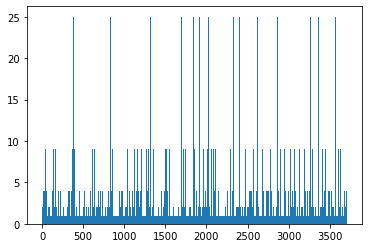

In [25]:
plt.hist(item_price.item, weights=item_price.price, bins=number_of_items)

In [35]:
item_price.groupby('price')['item'].nunique()

price
1     1326
2      896
4      709
9      589
25     186
Name: item, dtype: int64

In [36]:
item_price.describe()

,item,price
count,3706.000000,3706.000000
mean,1852.500000,4.291689
std,1069.974377,5.496992
min,0.000000,1.000000
25%,926.250000,1.000000
50%,1852.500000,2.000000
75%,2778.750000,4.000000
max,3705.000000,25.000000


There are 3706 items with prices distributed from [1, 2, 4, 9, 25].<br>
From the histogram and the data we see that most of the items are priced 2 and lower - ((1: 1326), (2: 896), (4: 709), (9: 589), (25: 186))<br>
It doesn't look like we can deduce a behaviour of a specific distribution (like normal/uniform etc.), especially since we don't have enough data other than ID numbers and prices...<br>

##### B) To evaluate the performance of the price sensitive model we add another metric Revenue@K which measures the overall revenue from the top 5 recommended hits.
Answer:

In [76]:
def revenue_at_K(df, column_name, K):
    ''' For each user: sum the prices of the top K recommended items which were rated as the revenue from the user '''
    result = df.nlargest(K, column_name)
    result_sum = result.sum()
    return result_sum[column_name]


# Calculate the mean revenue from all users

print(revenue_at_K(item_price, 'price', 5))

125


##### C) Suggest a metric of your own which will incorporate both the ranking of the recommended items as well as its price. Explain why this metric is suitable and demonstrate it as part of the evaluation in point e below.
Answer:

##### D) Select one of the models presented in the Neural Collaborative Filtering paper and incorporate the movie price to the loss function as part of training
Answer:

In [78]:
def get_GMF_model(num_users, num_items, latent_dim, regs=None, activation='sigmoid'):
    '''Generalized Matrix Factorization'''

    if not regs:
        regs = [[0,0]]
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent]) #merge([user_latent, item_latent], mode = 'mul')
    
    # Final prediction layer
    prediction = Dense(1, activation=activation, kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    
    return model

##### E) 
Answer:

***
## Question 3: Loss function
##### Answer: